In [1]:
import qiskit
from qiskit import Aer
from qiskit.quantum_info import state_fidelity
import numpy as np
from numpy import linalg as LA
import qib
import matplotlib.pyplot as plt

import sys
sys.path.append("../../src/groundstate_prep")
from ground_state_prep_qiskit import qetu_rqc_oneLayer


# Parameters for the Ising Hamiltonian
# L has to be even! Due to K only being able to control even Ls!
L, J, g = (10, 1, 1)

# construct Hamiltonian
latt = qib.lattice.IntegerLattice((L,), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
hamil = qib.IsingHamiltonian(field, J, 0, g).as_matrix().toarray()

eigenvalues, eigenvectors = LA.eig(hamil)
idx = eigenvalues.argsort()
eigenvalues_sort = eigenvalues[idx]
eigenvectors_sort = eigenvectors[:,idx]
ground_state = eigenvectors_sort[:, 0]
print("Ground State Energy", -eigenvalues_sort[-1].real)

dist = 1e-5

# Apriori Knowledge!
max_spectrum_length = 40
spectrum_lower_bound = -20

c1 = (np.pi-2*dist) / (max_spectrum_length)
c2 = dist - c1 * spectrum_lower_bound

eigenvalues_tr = eigenvalues_sort * c1 + c2
a_values = np.array([np.cos(eig/2) for eig in eigenvalues_tr])
print("t: ", c1/2)

print(a_values[:5])
print(eigenvalues_sort[:5])

ket_0 = np.array([1,0])
vec = np.sqrt(0.5) * eigenvectors_sort[:, 0] + np.sqrt(0.5) * eigenvectors_sort[:, 1]

/opt/anaconda3/envs/qc/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/anaconda3/envs/qc/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Ground State Energy -12.784906442999349
t:  0.039269658169872414
[0.96012726-0.j 0.9583809 -0.j 0.94523441-0.j 0.94339972-0.j
 0.94339972-0.j]
[-12.78490644+0.j -12.62750303+0.j -11.53343072+0.j -11.39143505+0.j
 -11.39143505+0.j]


In [2]:
sys.path.append("../../src/profiling")
from profiling import moment


D, beta = (7, 50)
strech = 1

backend = Aer.get_backend("statevector_simulator")
qc_RQC = qiskit.QuantumCircuit(L+1, 1)
qc_RQC.initialize(np.kron(ket_0, vec))

c1 = 2/(max_spectrum_length)
c1 = c1 * strech

/var/folders/l5/dy5jxrx94_98nf6d030tcw640000gn/T/ipykernel_42457/3537273284.py:8: DeprecationWarning: The 'qiskit.Aer' entry point is deprecated and will be removed in Qiskit 1.0. You should use 'qiskit_aer.Aer' directly instead.
  backend = Aer.get_backend("statevector_simulator")


In [3]:
moments = [moment(qc_RQC, L, J, g, eigenvalues_sort, k, c1, c2=0,
                  shots=1e3, depolar=1e-3
                 ) if k%2==1 else 0 for k in range(1, D+1)]

mom_b = [np.conj(moment) for moment in moments]
mom_b.reverse()
moments = mom_b + [1] + moments

t:  0.025
dt:  0.025
nsteps:  1
NoiseModel:
  Basis gates: ['cu', 'cx', 'cy', 'cz', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u2', 'cu', 'cy', 'cx', 'cz', 'u1', 'u3']
  All-qubits errors: ['u1', 'u2', 'u3', 'cu', 'cx', 'cy', 'cz']
getting counts
t:  0.07500000000000001
dt:  0.07500000000000001
nsteps:  1
NoiseModel:
  Basis gates: ['cu', 'cx', 'cy', 'cz', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u2', 'cu', 'cy', 'cx', 'cz', 'u1', 'u3']
  All-qubits errors: ['u1', 'u2', 'u3', 'cu', 'cx', 'cy', 'cz']
getting counts
t:  0.125
dt:  0.125
nsteps:  1
NoiseModel:
  Basis gates: ['cu', 'cx', 'cy', 'cz', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u2', 'cu', 'cy', 'cx', 'cz', 'u1', 'u3']
  All-qubits errors: ['u1', 'u2', 'u3', 'cu', 'cx', 'cy', 'cz']
getting counts
t:  0.17500000000000002
dt:  0.17500000000000002
nsteps:  1
NoiseModel:
  Basis gates: ['cu', 'cx', 'cy', 'cz', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions wi

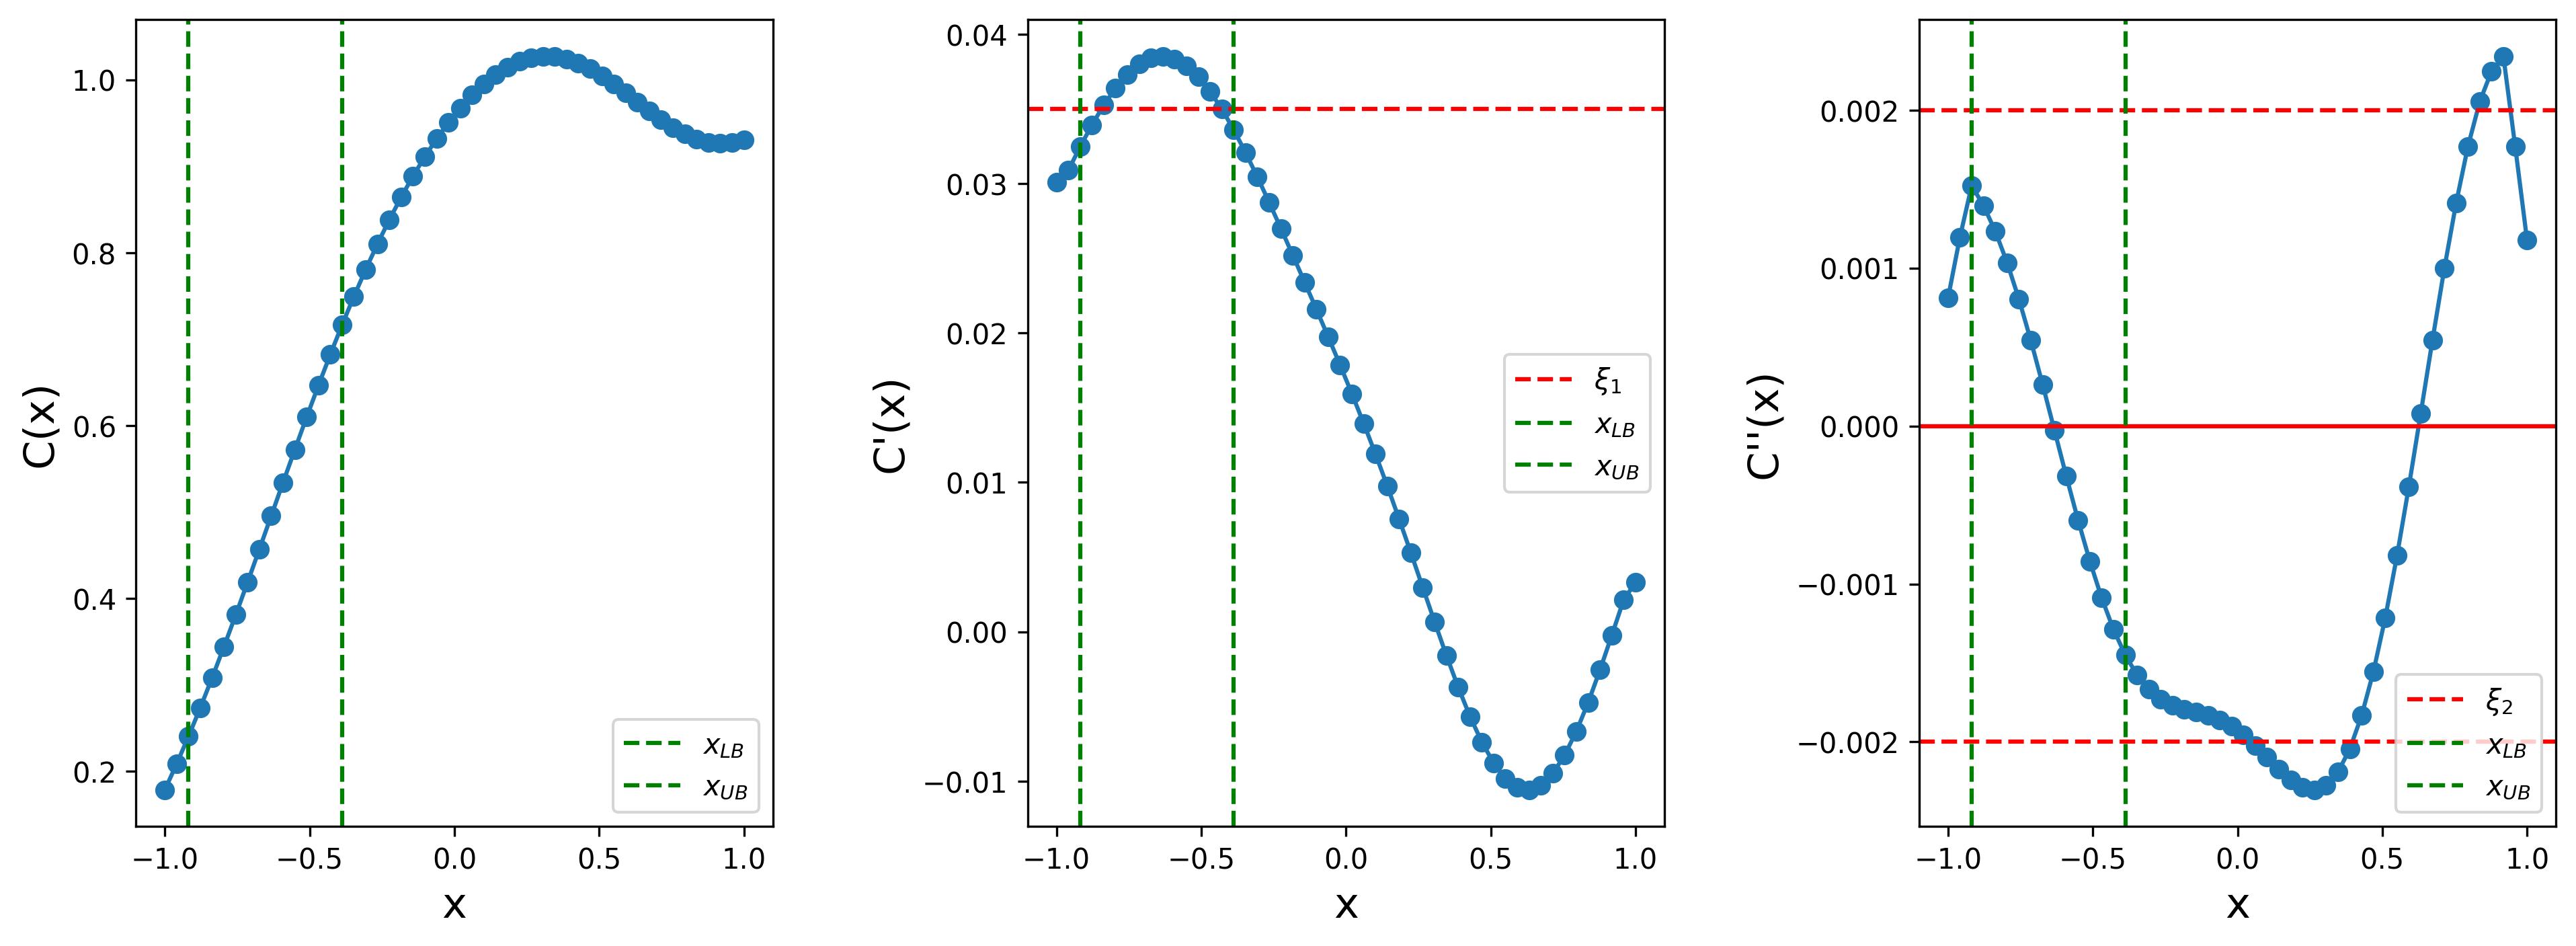

In [5]:
from profiling import C

x_values = np.linspace(-1, 1, 50)
cdf = [C(x, D, moments, beta=beta) for x in x_values]

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.rcParams["figure.figsize"] = (15,5)
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300


plt.subplot(131)
plt.plot(x_values, cdf)
plt.scatter(x_values, cdf)
plt.axvline(x_values[2], color="green", ls="--", label=r"$x_{LB}$")
plt.axvline(x_values[15], color="green", ls="--", label=r"$x_{UB}$")
plt.xlabel("x", size=15)
plt.ylabel("C(x)", size=15)
plt.legend()


plt.subplot(132)
cdf_dot = np.gradient(cdf)
plt.plot(x_values, cdf_dot)
plt.scatter(x_values, cdf_dot)
plt.axhline(0.035, color="red", ls="--", label=r"$\xi_1$")
plt.axvline(x_values[2], color="green", ls="--", label=r"$x_{LB}$")
plt.axvline(x_values[15], color="green", ls="--", label=r"$x_{UB}$")
plt.xlabel("x", size=15)
plt.ylabel("C'(x)", size=15)
plt.legend()

plt.subplot(133)
cdf_dot2 = np.gradient(cdf_dot)
plt.plot(x_values, cdf_dot2)
plt.axhline(0, color="red")
plt.axhline(2e-3, color="red", ls="--", label=r"$\xi_2$")
plt.axhline(-2e-3, color="red", ls="--")
plt.scatter(x_values, cdf_dot2)
plt.axvline(x_values[2], color="green", ls="--", label=r"$x_{LB}$")
plt.axvline(x_values[15], color="green", ls="--", label=r"$x_{UB}$")
plt.xlabel("x", size=15)
plt.ylabel("C''(x)", size=15)
plt.legend()

plt.show()

In [6]:
x_values = np.linspace(-1, 1, 50)
print("Estimated new spectrum:", np.array([x_values[2], x_values[15]])/c1, "\n")

Estimated new spectrum: [-18.36734694  -7.75510204] 



In [7]:
# Assumptions!
spectrum_upper_bound = -7.75510204
spectrum_lower_bound = -18.36734694
max_spectrum_length = spectrum_upper_bound - spectrum_lower_bound

D, beta = (7, 50)

c1 = 2/(max_spectrum_length)
c1 = c1
c2 =  - c1 * spectrum_lower_bound - 1
eigenvalues_tr = eigenvalues_sort * c1 + c2
print(eigenvalues_tr[:6])

[0.05207532+0.j 0.08173981+0.j 0.28793036+0.j 0.31469109+0.j
 0.31469109+0.j 0.51224184+0.j]


In [18]:
sys.path.append("../../src/profiling")
from profiling import moment

moments = [moment(qc_RQC, L, J, g, eigenvalues_sort, k, c1, c2=0,
                  psi=vec,
                  shots=1e3, depolar=1e-10
                 ) if k%2==1 else 0 for k in range(1, D+1)]

mom_b = [np.conj(moment) for moment in moments]
mom_b.reverse()
moments = mom_b + [1] + moments

t:  0.09423076921264793
dt:  0.09423076921264793
nsteps:  1
NoiseModel:
  Basis gates: ['cu', 'cx', 'cy', 'cz', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u2', 'cu', 'cy', 'cx', 'cz', 'u1', 'u3']
  All-qubits errors: ['u1', 'u2', 'u3', 'cu', 'cx', 'cy', 'cz']
getting counts
t:  0.2826923076379438
dt:  0.2826923076379438
nsteps:  1
NoiseModel:
  Basis gates: ['cu', 'cx', 'cy', 'cz', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u2', 'cu', 'cy', 'cx', 'cz', 'u1', 'u3']
  All-qubits errors: ['u1', 'u2', 'u3', 'cu', 'cx', 'cy', 'cz']
getting counts
t:  0.4711538460632397
dt:  0.4711538460632397
nsteps:  1
NoiseModel:
  Basis gates: ['cu', 'cx', 'cy', 'cz', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u2', 'cu', 'cy', 'cx', 'cz', 'u1', 'u3']
  All-qubits errors: ['u1', 'u2', 'u3', 'cu', 'cx', 'cy', 'cz']
getting counts
t:  0.6596153844885355
dt:  0.6596153844885355
nsteps:  1
NoiseModel:
  Basis gates: ['cu', 'cx', 'cy', 'cz', 'id

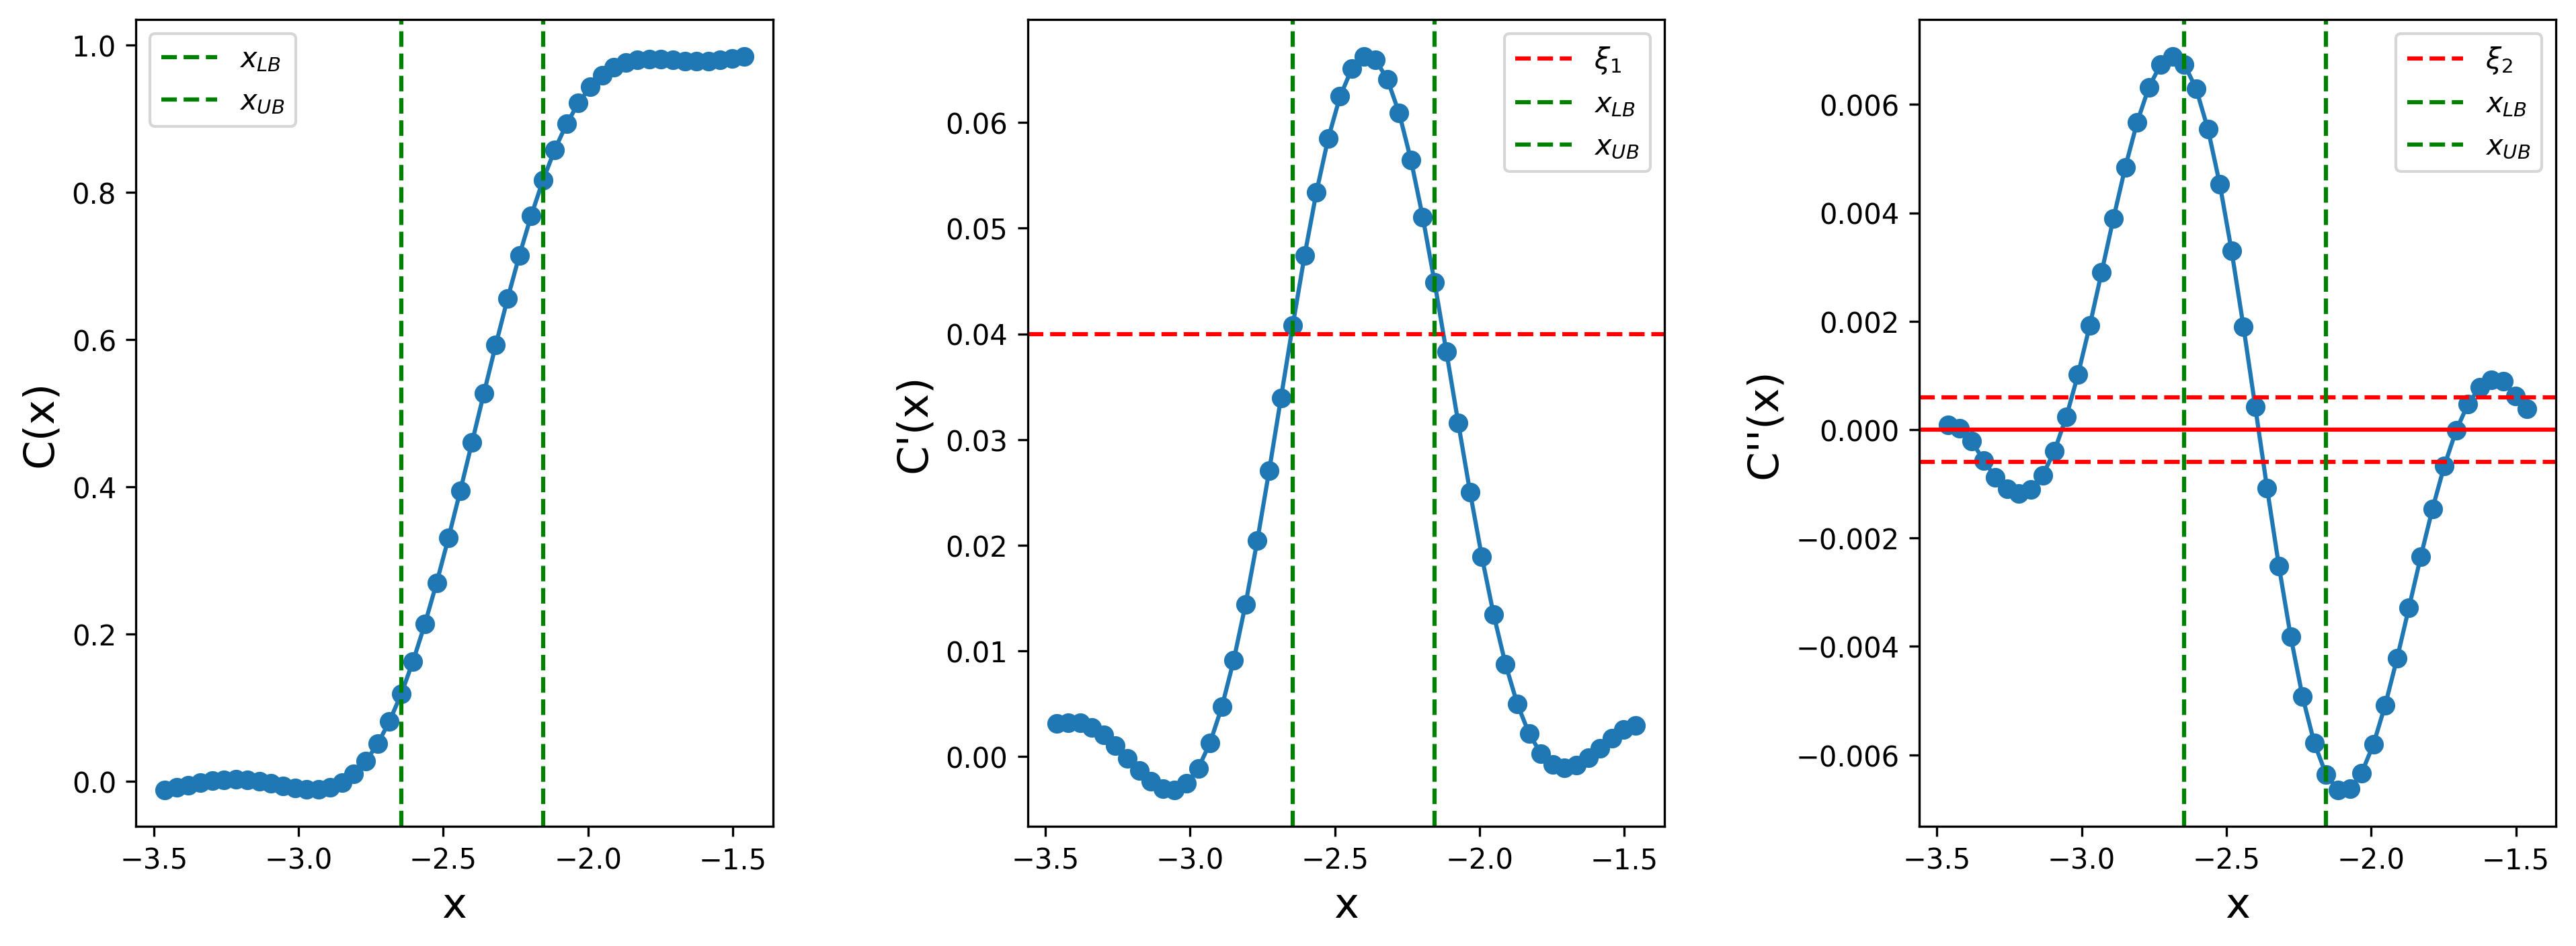

In [27]:
from profiling import C

x_values = np.linspace(-c2-1, -c2+1, 50)
cdf = [C(x, D, moments, beta=beta) for x in x_values]

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.rcParams["figure.figsize"] = (15,5)
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300


plt.subplot(131)
plt.plot(x_values, cdf)
plt.scatter(x_values, cdf)
plt.axvline(x_values[20], color="green", ls="--", label=r"$x_{LB}$")
plt.axvline(x_values[32], color="green", ls="--", label=r"$x_{UB}$")
plt.xlabel("x", size=15)
plt.ylabel("C(x)", size=15)
plt.legend()


plt.subplot(132)
cdf_dot = np.gradient(cdf)
plt.plot(x_values, cdf_dot)
plt.scatter(x_values, cdf_dot)
plt.axhline(4e-2, color="red", ls="--", label=r"$\xi_1$")
plt.axvline(x_values[20], color="green", ls="--", label=r"$x_{LB}$")
plt.axvline(x_values[32], color="green", ls="--", label=r"$x_{UB}$")
plt.xlabel("x", size=15)
plt.ylabel("C'(x)", size=15)
plt.legend()

plt.subplot(133)
cdf_dot2 = np.gradient(cdf_dot)
plt.plot(x_values, cdf_dot2)
plt.axhline(0, color="red")
plt.axhline(6e-4, color="red", ls="--", label=r"$\xi_2$")
plt.axhline(-6e-4, color="red", ls="--")
plt.scatter(x_values, cdf_dot2)
plt.axvline(x_values[20], color="green", ls="--", label=r"$x_{LB}$")
plt.axvline(x_values[32], color="green", ls="--", label=r"$x_{UB}$")
plt.xlabel("x", size=15)
plt.ylabel("C''(x)", size=15)
plt.legend()

plt.show()

In [28]:
x_values = np.linspace(-c2-1, -c2+1, 50)
print("Estimated new spectrum:", np.array([x_values[20], x_values[32]])/c1, "\n")
print(eigenvalues_sort[:7]* c1)

Estimated new spectrum: [-14.03581841 -11.43690129] 

[-2.40946314+0.j -2.37979865+0.j -2.1736081 +0.j -2.14684737+0.j
 -2.14684737+0.j -1.94929663+0.j -1.94929663+0.j]


In [29]:
# Assumptions!
spectrum_upper_bound = -11.43690129
spectrum_lower_bound = -14.03581841
max_spectrum_length = spectrum_upper_bound - spectrum_lower_bound

D, beta = (7, 50)

c1 = 2/(max_spectrum_length)
c2 =  - c1 * spectrum_lower_bound - 1
eigenvalues_tr = eigenvalues_sort * c1 + c2
print(eigenvalues_tr[:6])

[-0.03735909+0.j  0.08377091+0.j  0.92571565+0.j  1.0349886 +0.j
  1.0349886 +0.j  1.84165416+0.j]


In [30]:
moments = [moment(qc_RQC, L, J, g, eigenvalues_sort, k, c1, c2=0,
                  shots=1e3, depolar=1e-10, psi=vec,
                 ) if k%2==1 else 0 for k in range(1, D+1)]

mom_b = [np.conj(moment) for moment in moments]
mom_b.reverse()
moments = mom_b + [1] + moments

t:  0.38477564070992776
dt:  0.38477564070992776
nsteps:  1
NoiseModel:
  Basis gates: ['cu', 'cx', 'cy', 'cz', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u2', 'cu', 'cy', 'cx', 'cz', 'u1', 'u3']
  All-qubits errors: ['u1', 'u2', 'u3', 'cu', 'cx', 'cy', 'cz']
coeffs_start_n5: [0.25, 0.5, 0.5, 0.5, 0.25]
getting counts
t:  1.1543269221297834
dt:  0.5771634610648917
nsteps:  2
NoiseModel:
  Basis gates: ['cu', 'cx', 'cy', 'cz', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u2', 'cu', 'cy', 'cx', 'cz', 'u1', 'u3']
  All-qubits errors: ['u1', 'u2', 'u3', 'cu', 'cx', 'cy', 'cz']
coeffs_start_n5: [0.25, 0.5, 0.5, 0.5, 0.25]
getting counts
t:  1.9238782035496387
dt:  0.9619391017748193
nsteps:  2
NoiseModel:
  Basis gates: ['cu', 'cx', 'cy', 'cz', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u2', 'cu', 'cy', 'cx', 'cz', 'u1', 'u3']
  All-qubits errors: ['u1', 'u2', 'u3', 'cu', 'cx', 'cy', 'cz']
coeffs_start_n5: [0.25, 0.5, 0.5, 0.5,

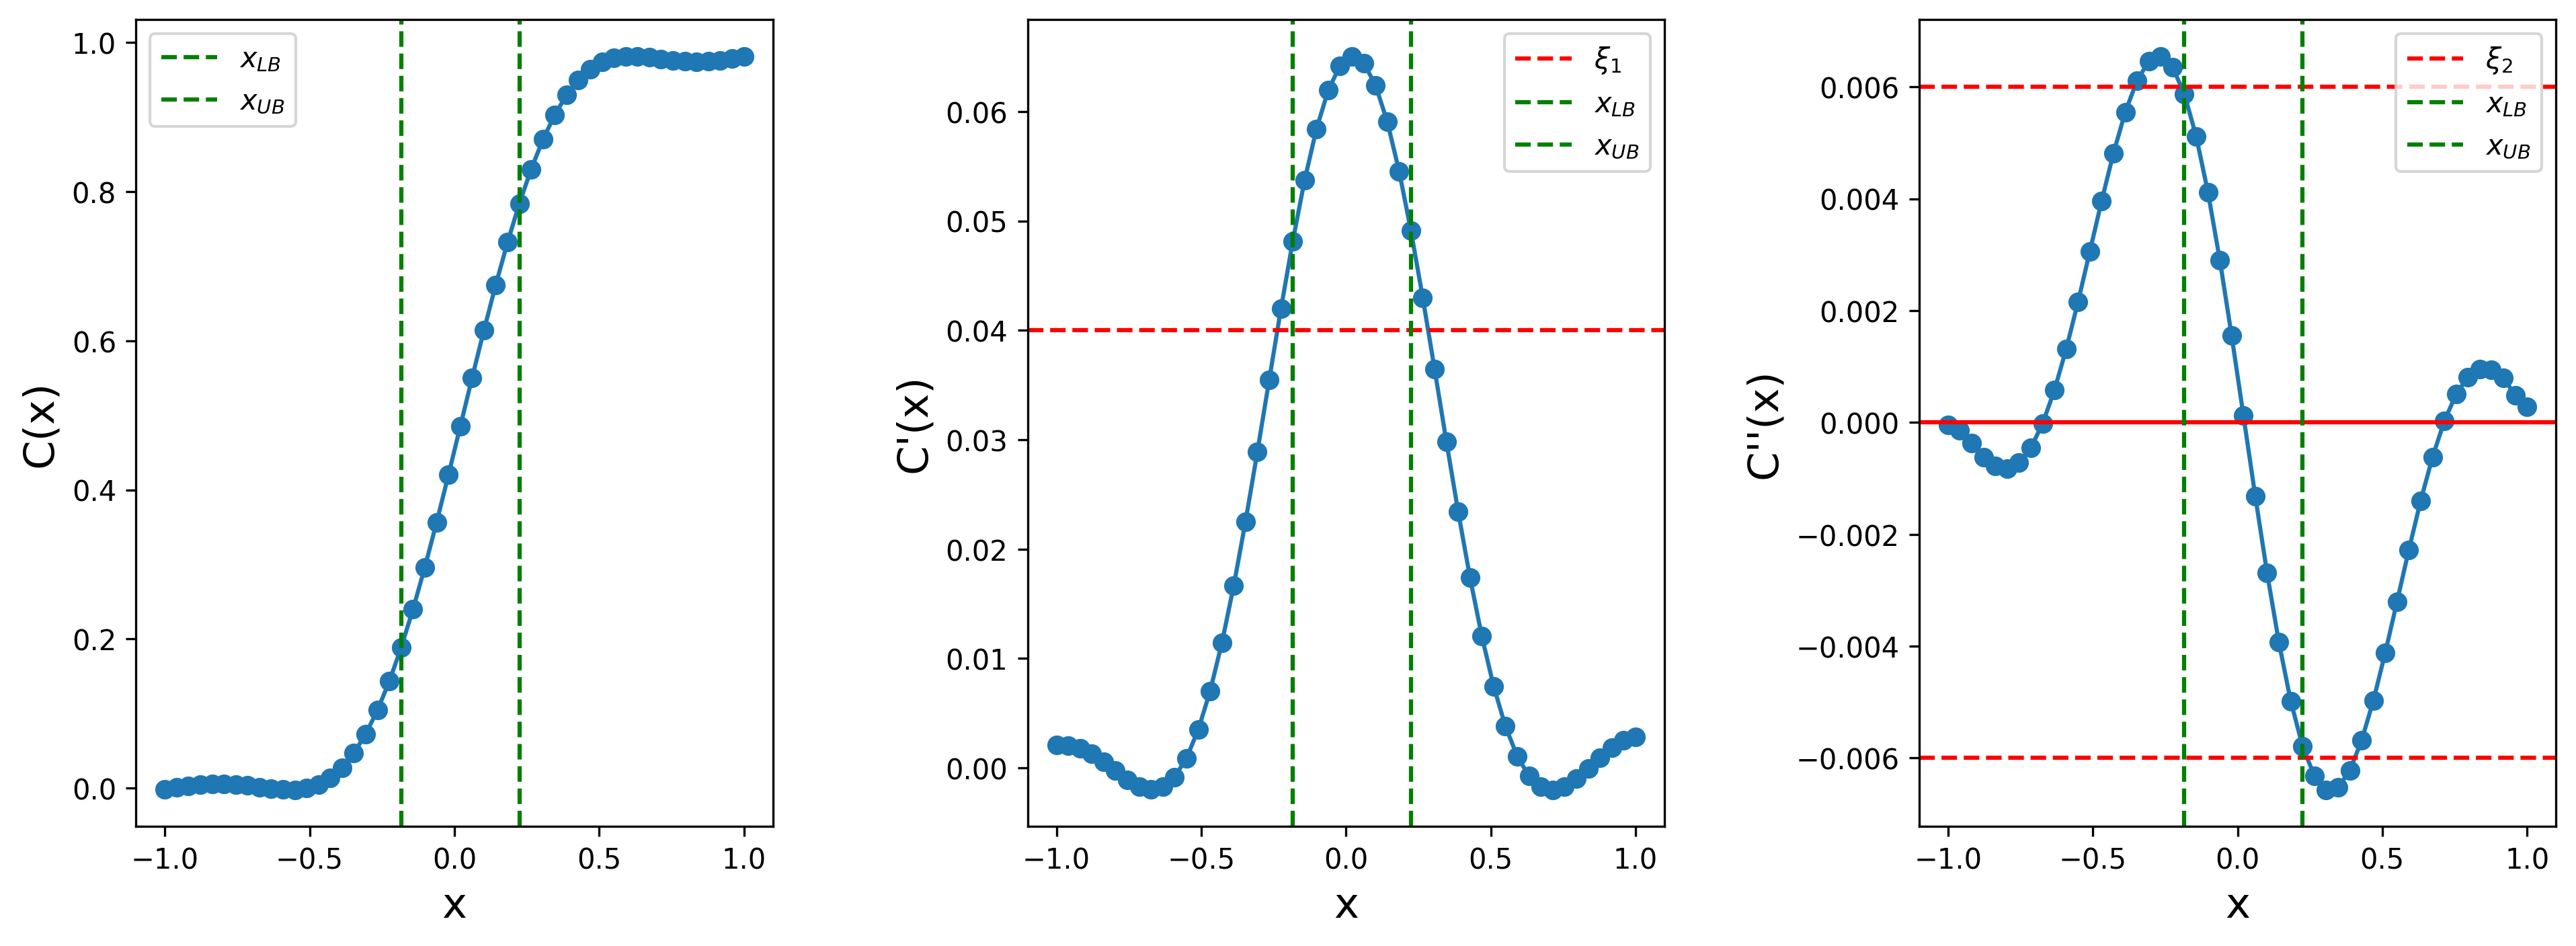

In [34]:
from profiling import C

x_values = np.linspace(-c2-1, -c2+1, 50)
cdf = [C(x, D, moments, beta=beta) for x in x_values]

x_values = np.linspace(-1, +1, 50)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9,
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.rcParams["figure.figsize"] = (15,5)
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300


plt.subplot(131)
plt.plot(x_values, cdf)
plt.scatter(x_values, cdf)
plt.axvline(x_values[20], color="green", ls="--", label=r"$x_{LB}$")
plt.axvline(x_values[30], color="green", ls="--", label=r"$x_{UB}$")
plt.xlabel("x", size=15)
plt.ylabel("C(x)", size=15)
plt.legend()

plt.subplot(132)
cdf_dot = np.gradient(cdf)
plt.plot(x_values, cdf_dot)
plt.scatter(x_values, cdf_dot)
plt.axhline(4e-2, color="red", ls="--", label=r"$\xi_1$")
plt.axvline(x_values[20], color="green", ls="--", label=r"$x_{LB}$")
plt.axvline(x_values[30], color="green", ls="--", label=r"$x_{UB}$")
plt.xlabel("x", size=15)
plt.ylabel("C'(x)", size=15)
plt.legend()

plt.subplot(133)
cdf_dot2 = np.gradient(cdf_dot)
plt.plot(x_values, cdf_dot2)
plt.axhline(0, color="red")
plt.axhline(6e-3, color="red", ls="--", label=r"$\xi_2$")
plt.axhline(-6e-3, color="red", ls="--")
plt.scatter(x_values, cdf_dot2)
plt.axvline(x_values[20], color="green", ls="--", label=r"$x_{LB}$")
plt.axvline(x_values[30], color="green", ls="--", label=r"$x_{UB}$")
plt.xlabel("x", size=15)
plt.ylabel("C''(x)", size=15)
plt.legend()

plt.show()

In [35]:
x_values = np.linspace(-c2-1, -c2+1, 50)
print("Estimated new spectrum:", np.array([x_values[20], x_values[30]])/c1, "\n")
print(eigenvalues_sort[:7]* c1)

Estimated new spectrum: [-12.97503591 -12.44464466] 

[-9.83864114+0.j -9.71751114+0.j -8.87556639+0.j -8.76629344+0.j
 -8.76629344+0.j -7.95962788+0.j -7.95962788+0.j]


In [60]:
spectrum_upper_bound = -12.44464466
spectrum_lower_bound = -12.97503591
max_spectrum_length = spectrum_upper_bound - spectrum_lower_bound

spectral_gap_guess = max_spectrum_length * 0.2
spectrum_lower_bound_guess = spectrum_lower_bound

c1 = 1/(spectral_gap_guess)
c2 = - c1 * spectrum_lower_bound_guess

eigenvalues_tr = eigenvalues_sort * c1 + c2
a_values = np.array([np.cos(eig/2) for eig in eigenvalues_tr])
print("t: ", c1/2)

print(a_values[:5])
print(eigenvalues_tr[:5])

t:  4.713501589628402
[ 0.62460121-0.j -0.06724967-0.j  0.87185309-0.j  0.37988916-0.j
  0.37988916-0.j]
[ 1.79235109+0.j  3.27619357+0.j 13.59001668+0.j 14.92861032+0.j
 14.92861032+0.j]


dt:  0.9427003179256804
Running decomposition of two-qubit gates of the RQC Circuit...
F(a_max)^2:  (0.07410283943369139+0j)
F(a_premax)^2:  (0.00017003505296340107+0j)
F(x)^2:  0.30739322524628754


/var/folders/l5/dy5jxrx94_98nf6d030tcw640000gn/T/ipykernel_42457/3205854263.py:18: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  bR = execute(transpile(qc_RQC), backend).result().get_statevector().data


Success Prob:  0.03756350069494639
Overlaps:  [0.9976025239118148, 0.0023284876206458483, 1.4400262721908443e-07]


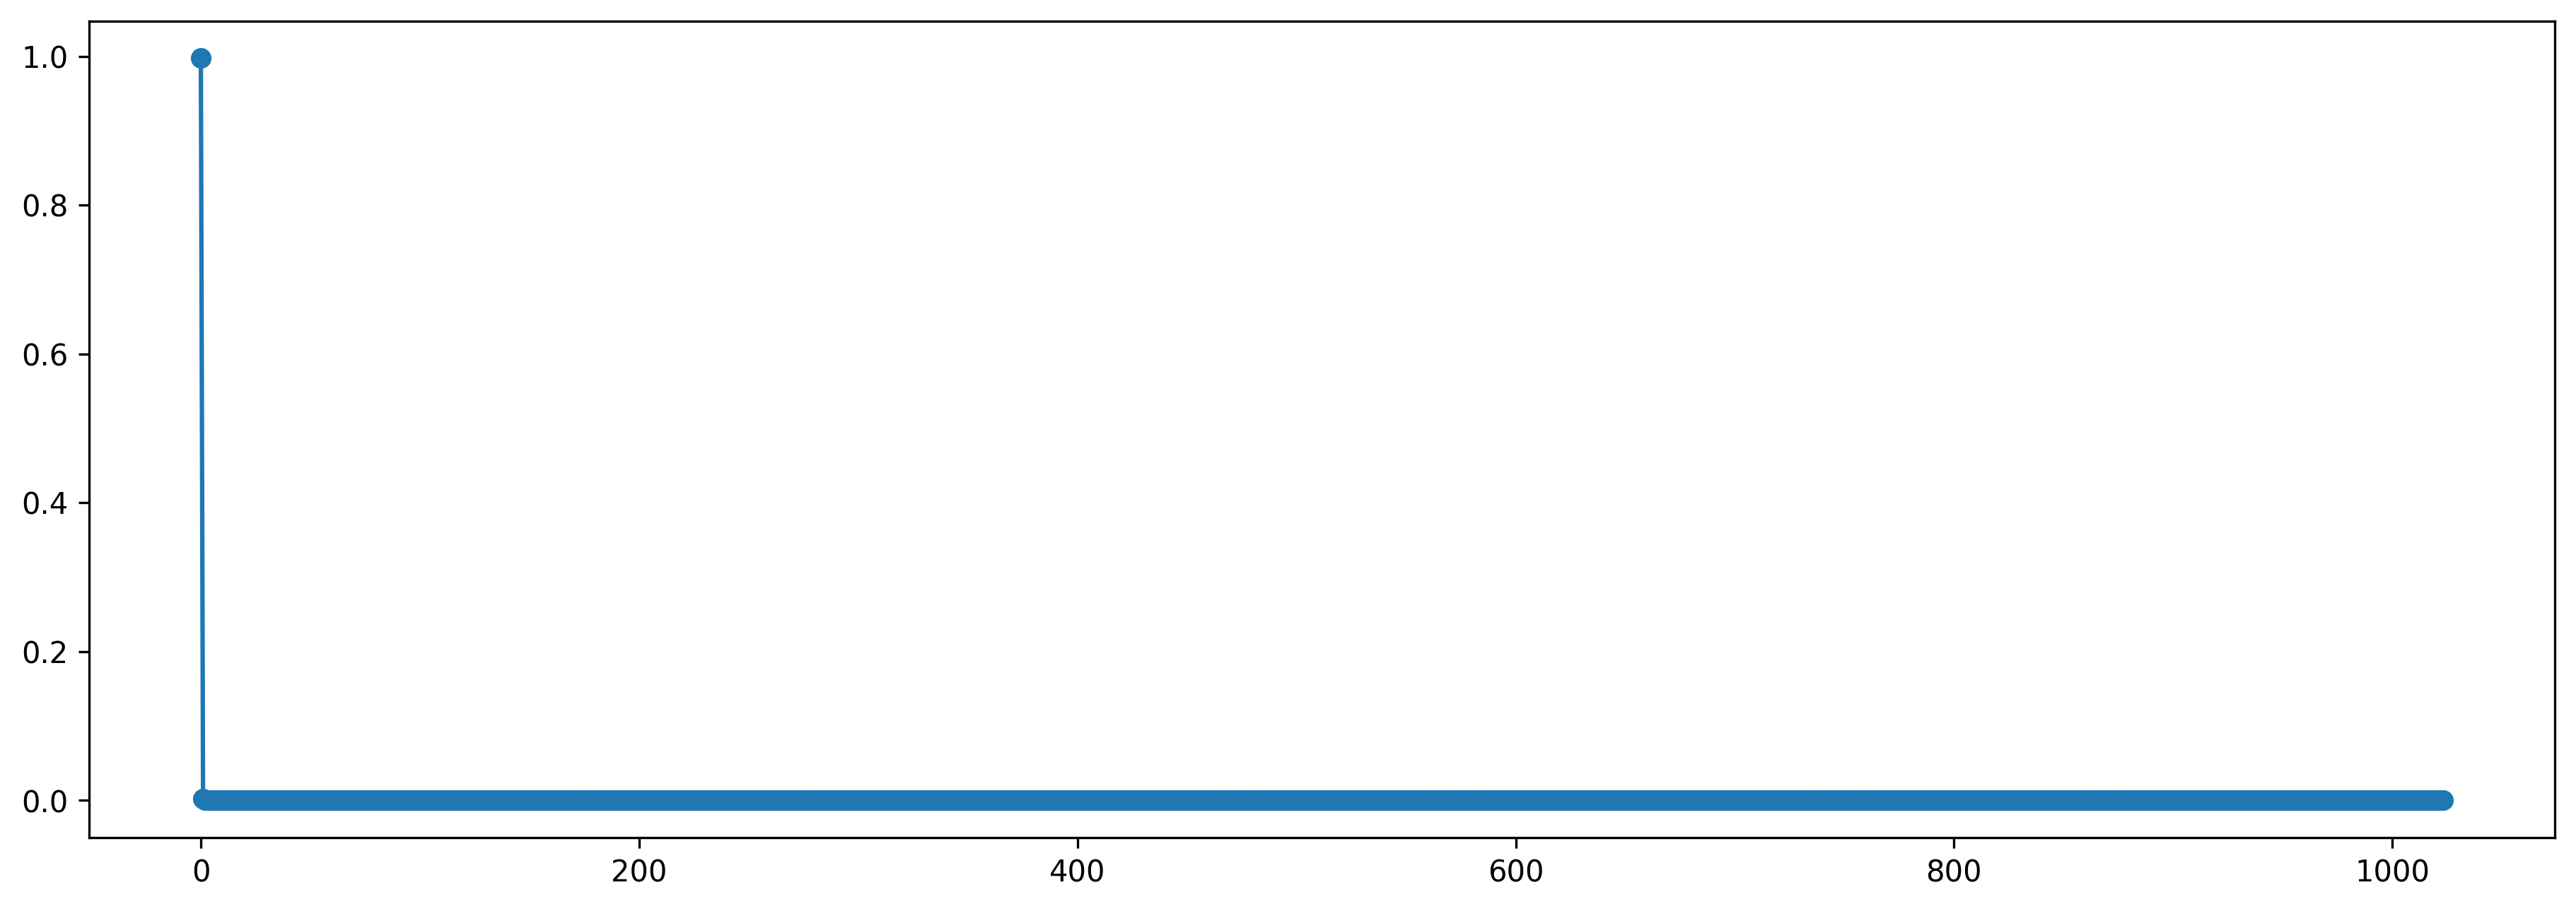

In [61]:
from qiskit import Aer, execute, transpile

ket_0 = np.array([1,0])
qcs_qetu = []

mu, d, c, phis_max_iter = (0.9, 4, 0.95, 10)
qc_qetu, phis_0, _ = qetu_rqc_oneLayer(L, J, g, c1/2, mu, a_values, d=d, c=c, 
                                           c2=c2, max_iter_for_phis=phis_max_iter, 
                                           reuse_RQC=6, split_U=int(np.ceil(c1/2)))
qcs_qetu.append(qc_qetu)
ground_state = eigenvectors_sort[:, 0]

backend = Aer.get_backend("statevector_simulator")
qc_RQC = qiskit.QuantumCircuit(L+1, L+1)
qc_RQC.initialize(np.kron(ket_0, vec))
for qc_qetu in qcs_qetu:
    qc_RQC.append(qc_qetu.to_gate(), [i for i in range(L+1)])
    bR = execute(transpile(qc_RQC), backend).result().get_statevector().data
    aR = np.kron(np.array([[1,0],[0,0]]), np.identity(2**L)) @ bR
    print("Success Prob: ", np.linalg.norm(aR)**2)
    aR = aR / np.linalg.norm(aR)
    qc_RQC.reset([i for i in range(L+1)])
    qc_RQC.initialize(aR)


toPlot = [state_fidelity(aR[:2**L], eigenvectors_sort[:, i]) for i in range(2**L)]
plt.plot([i for i in range(len(toPlot))], toPlot)
plt.scatter([i for i in range(len(toPlot))], toPlot)

print("Overlaps: ", toPlot[0:3])
plt.show()

In [62]:
# construct Hamiltonian
latt = qib.lattice.IntegerLattice((L,), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
hamil = qib.IsingHamiltonian(field, J, 0, g).as_matrix().toarray()

eigenvalues, eigenvectors = LA.eig(hamil)
idx = eigenvalues.argsort()
eigenvalues_sort = eigenvalues[idx]
eigenvectors_sort = eigenvectors[:,idx]
ground_state = eigenvectors_sort[:, 0]
print("Ground State Energy", -eigenvalues_sort[-1].real)

# Apriori Knowledge!
max_spectrum_length = 40
spectrum_lower_bound = -20

c1 = (np.pi-2*dist) / (max_spectrum_length)
c2 = dist - c1 * spectrum_lower_bound

eigenvalues_tr = eigenvalues_sort * c1 + c2
a_values = np.array([np.cos(eig/2) for eig in eigenvalues_tr])
print("t: ", c1/2)

print(a_values[:5])
print(eigenvalues_sort[:5])

Ground State Energy -12.784906442999349
t:  0.039269658169872414
[0.96012726-0.j 0.9583809 -0.j 0.94523441-0.j 0.94339972-0.j
 0.94339972-0.j]
[-12.78490644+0.j -12.62750303+0.j -11.53343072+0.j -11.39143505+0.j
 -11.39143505+0.j]


In [ ]:
from qiskit import Aer, execute, transpile

ket_0 = np.array([1,0])

mu, d, c, phis_max_iter = (0.959, 30, 0.95, 10)
qc_qetu, phis_0, _ = qetu_rqc_oneLayer(L, J, g, c1/2, mu, a_values, d=d, c=c, 
                                           c2=c2, max_iter_for_phis=phis_max_iter, 
                                           reuse_RQC=6, split_U=int(np.ceil(c1/2)))
ground_state = eigenvectors_sort[:, 0]

backend = Aer.get_backend("statevector_simulator")
qc_RQC = qiskit.QuantumCircuit(L+1, L+1)
qc_RQC.initialize(np.kron(ket_0, vec))

overlaps = []
for qc_qetu in [qc_qetu for i in range(50)]:
    qc_RQC.append(qc_qetu.to_gate(), [i for i in range(L+1)])
    bR = execute(transpile(qc_RQC), backend).result().get_statevector().data
    aR = np.kron(np.array([[1,0],[0,0]]), np.identity(2**L)) @ bR
    #print("Success Prob: ", np.linalg.norm(aR)**2)
    aR = aR / np.linalg.norm(aR)
    qc_RQC.reset([i for i in range(L+1)])
    qc_RQC.initialize(aR)
    #print("Overlap: ", state_fidelity(aR[:2**L], eigenvectors_sort[:, 0]))
    overlaps.append(state_fidelity(aR[:2**L], eigenvectors_sort[:, 0]))

toPlot = [state_fidelity(aR[:2**L], eigenvectors_sort[:, i]) for i in range(2**L)]
plt.plot([i for i in range(len(toPlot))], toPlot)
plt.scatter([i for i in range(len(toPlot))], toPlot)

print("Overlaps: ", toPlot[0:3])
plt.show()

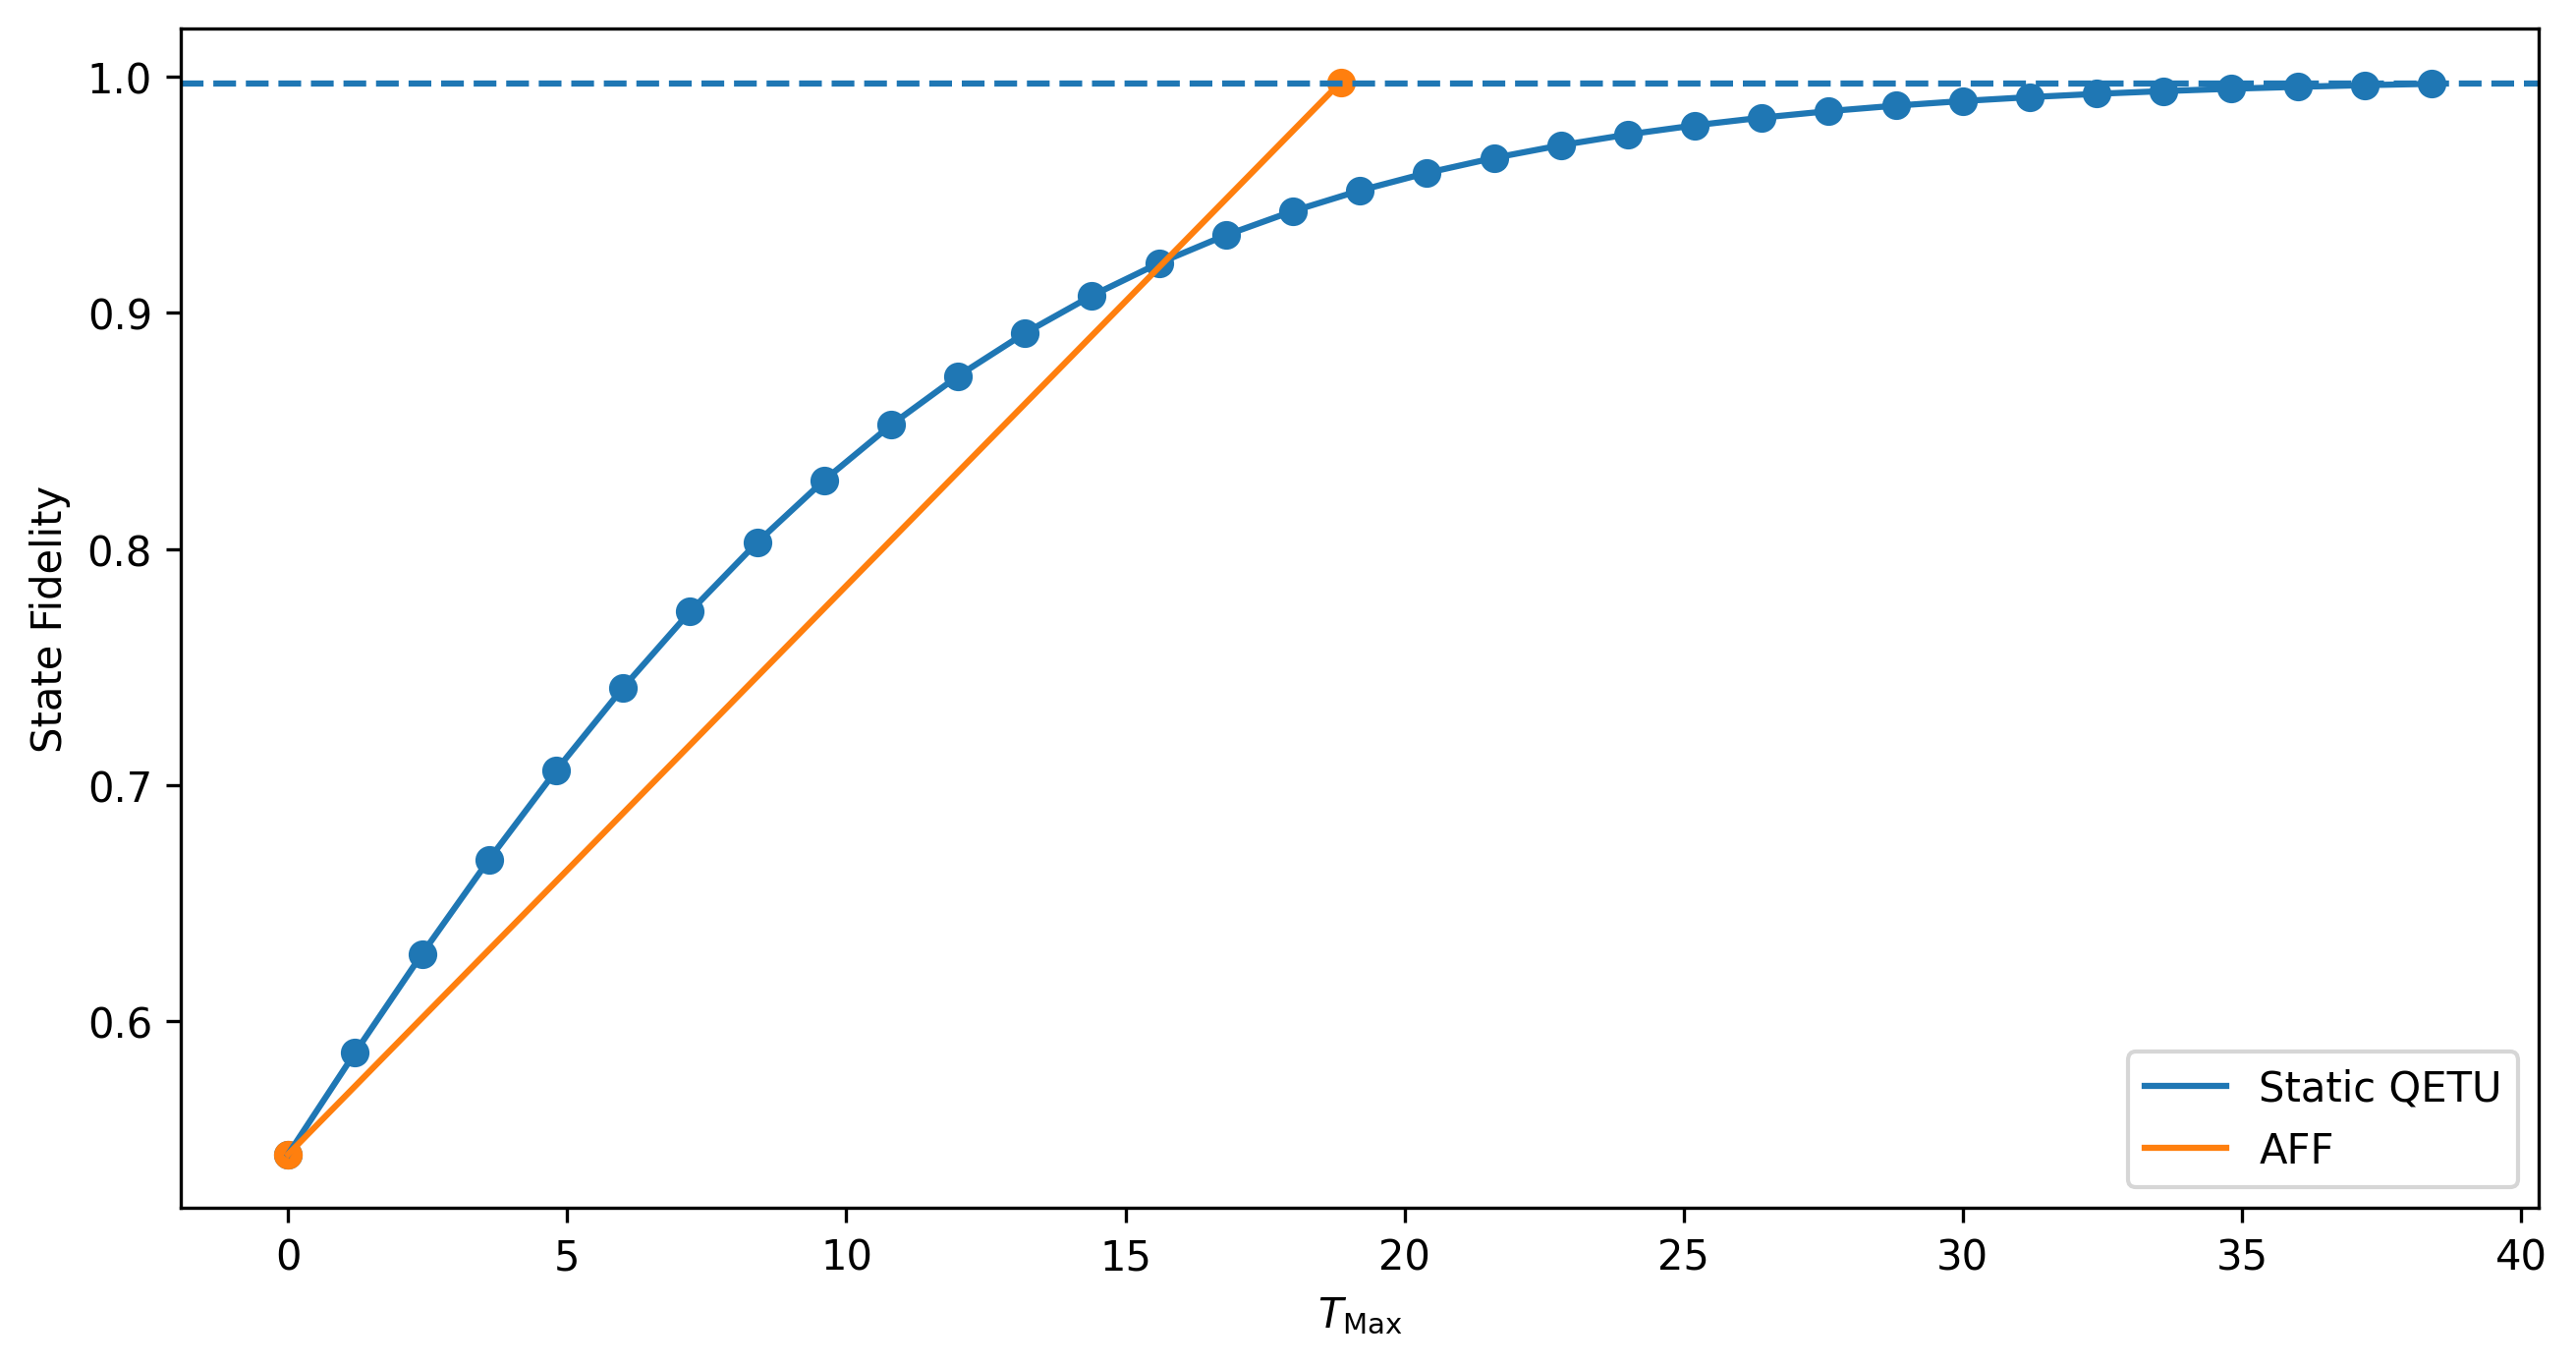

In [76]:
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.rcParams["figure.figsize"] = (10, 5)
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300


plt.plot([0.04 * 30 * i for i in range(33)],  overlaps[:33], label="Static QETU")
plt.scatter([0.04 * 30 * i for i in range(33)],  overlaps[:33])

plt.plot([0, 4.7135 * 4], [overlaps[0], 0.9976], label="AFF")
plt.scatter([0, 4.7135 * 4], [overlaps[0], 0.9976])

plt.ylabel("State Fidelity")
plt.xlabel(r"$T_{\text{Max}}$")

plt.axhline(overlaps[32], ls="--")
plt.legend()
plt.savefig("../../figs/TFIM10_high_overlap.pdf")